In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import seaborn as sns
import os
import admix
from os.path import join
import itertools
import admix_genet_cor
import submitit
import glob
from scipy.stats import pearsonr, linregress
from tqdm import tqdm
import string
import pickle

In [2]:
# define the simulation parameters
df_real_params = pd.DataFrame(
    [
        params
        for params in itertools.product(
            ["real"],
            [f"region{i}" for i in np.arange(100)],
            [0.002, 0.006, 0.01],
            [1],
        )
    ],
    columns=["group", "region", "hsq", "ncausal"],
)
df_simu_params = pd.DataFrame(
    [
        params
        for params in itertools.product(
            ["simu"],
            [f"region{i}.eur20.afr80" for i in np.arange(50)],
            [f"region{i}.eur80.afr20" for i in np.arange(50)],
            [0.002, 0.006, 0.01],
            [1, 41],
        )
    ],
    columns=["group", "region", "hsq", "ncausal"],
)
df_params = pd.concat([df_real_params, df_simu_params])
df_params = df_real_params
df_params["config"] = df_params.apply(
    lambda row: f"group-{row.group}-region-{row.region}-hsq-{row.hsq}-ncausal-{int(row.ncausal)}",
    axis=1,
)

In [3]:
result_file = "results/dict_df_res.pkl"
if os.path.exists(result_file):
    with open(result_file, "rb") as f:
        dict_df_res = pickle.load(f)
else:
    dict_df_res = {}

    for group in ["causal", "clump"]:
        df_res = []
        for param_i, param in tqdm(df_params.iterrows(), total=len(df_params)):
            for sim_i in range(100):
                path = f"out/covar-pc/summary/{param.config}/sim_{sim_i}.{group}.tsv"
                if os.path.exists(path):
                    df_tmp = pd.read_csv(path, sep="\t")
                    df_tmp["group"] = param.group
                    df_tmp["region"] = param.region
                    df_tmp["ncausal"] = param.ncausal
                    df_tmp["hsq"] = param.hsq
                    df_tmp["sim_i"] = sim_i
                    df_res.append(df_tmp)

        df_res = pd.concat(df_res).reset_index(drop=True)
        # filter for SNPs with super small MAF in either one of the populations
        df_res = df_res[(df_res.se1 > 1e-6) & (df_res.se2 > 1e-6)]
        print(group, np.mean(df_res.het_pval < 0.05))
        dict_df_res[group] = df_res

    with open(result_file, "wb") as f:
        pickle.dump(dict_df_res, f)

# additional results where in each simulation, we only retain the variants
# with strongest association
dict_df_res["clump-max"] = (
    dict_df_res["clump"]
    .sort_values("assoc_p", ascending=True)
    .drop_duplicates(["region", "ncausal", "hsq", "sim_i"])
)

In [4]:
df_causal = dict_df_res["causal"].copy()
df_clump = dict_df_res["clump"].copy()


df_merged = pd.merge(
    left=df_clump[["snp", "region", "ncausal", "hsq", "sim_i"]],
    right=df_causal[["snp", "region", "ncausal", "hsq", "sim_i"]],
    left_on=["region", "ncausal", "hsq", "sim_i"],
    right_on=["region", "ncausal", "hsq", "sim_i"],
)

print("All clumped results")
display(
    df_merged.groupby(["ncausal", "hsq"]).apply(
        lambda d: np.mean(d["snp_x"] == d["snp_y"])
    )
)

df_causal = dict_df_res["causal"].copy()
df_clump = dict_df_res["clump-max"].copy()


df_merged = pd.merge(
    left=df_clump[["snp", "region", "ncausal", "hsq", "sim_i"]],
    right=df_causal[["snp", "region", "ncausal", "hsq", "sim_i"]],
    left_on=["region", "ncausal", "hsq", "sim_i"],
    right_on=["region", "ncausal", "hsq", "sim_i"],
)

print("\nmax clumped results")
display(
    df_merged.groupby(["ncausal", "hsq"]).apply(
        lambda d: np.mean(d["snp_x"] == d["snp_y"])
    )
)

All clumped results


ncausal  hsq  
1        0.002    0.449811
         0.006    0.514793
         0.010    0.356332
dtype: float64


max clumped results


ncausal  hsq  
1        0.002    0.452747
         0.006    0.574372
         0.010    0.631163
dtype: float64

# Comparing the distance between clumped variants and causal variants using (1) max association (2) secondary association

In [5]:
df_clump_max = dict_df_res["clump-max"]

df_merged = pd.merge(
    left=df_clump_max[["snp", "region", "ncausal", "hsq", "sim_i"]],
    right=df_causal[["snp", "region", "ncausal", "hsq", "sim_i"]],
    left_on=["region", "ncausal", "hsq", "sim_i"],
    right_on=["region", "ncausal", "hsq", "sim_i"],
)
df_merged = df_merged[df_merged.hsq == 0.01]
dist_max = (
    df_merged.apply(
        lambda r: int(r["snp_x"].split(":")[1]) - int(r["snp_y"].split(":")[1]), axis=1
    ).abs()
    / 1000
)

df_clump_secondary = dict_df_res["clump"].sort_values("assoc_p", ascending=True)
df_clump_secondary = df_clump_secondary[
    df_clump_secondary.duplicated(["region", "ncausal", "hsq", "sim_i"])
]

df_merged = pd.merge(
    left=df_clump_secondary[["snp", "region", "ncausal", "hsq", "sim_i"]],
    right=df_causal[["snp", "region", "ncausal", "hsq", "sim_i"]],
    left_on=["region", "ncausal", "hsq", "sim_i"],
    right_on=["region", "ncausal", "hsq", "sim_i"],
)
df_merged = df_merged[df_merged.hsq == 0.01]
dist_secondary = (
    df_merged.apply(
        lambda r: int(r["snp_x"].split(":")[1]) - int(r["snp_y"].split(":")[1]), axis=1
    ).abs()
    / 1000
)

print(
    f"Distance: mean: {np.mean(dist_max):.2f}, SEM: {np.std(dist_max) / np.sqrt(len(dist_max)):.2f}"
)
print(
    f"Distance: mean: {np.mean(dist_secondary):.2f}, SEM: {np.std(dist_secondary) / np.sqrt(len(dist_secondary)):.2f}"
)

Distance: mean: 2.44, SEM: 0.07
Distance: mean: 432.52, SEM: 14.41


In [6]:
def summarize_res(df_res_grouped):
    # 1st local ancestry = AFR, 2nd local ancestry = EUR
    df_plot = pd.DataFrame(
        {
            "het_inflation": df_res_grouped.apply(
                lambda x: admix.data.lambda_gc(x["het_pval"])
            ),  # HET p-value
            "het_fpr": df_res_grouped.apply(lambda x: np.mean(x["het_pval"] < 0.05)),
            "pearsonr": df_res_grouped.apply(
                lambda x: pearsonr(x["coef1"], x["coef2"])[0]
            ),  # Pearson's correlation between two coefficents
            "deming_afr~eur": df_res_grouped.apply(
                lambda x: admix_genet_cor.locus.deming_regression(
                    x=x["coef1"], y=x["coef2"], sx=x["se1"], sy=x["se2"]
                )[0]
            ),  # EUR ~ AFR
            "deming_eur~afr": df_res_grouped.apply(
                lambda x: admix_genet_cor.locus.deming_regression(
                    x=x["coef2"], y=x["coef1"], sx=x["se2"], sy=x["se1"]
                )[0]
            ),  # AFR ~ EUR
            "ols_afr~eur": df_res_grouped.apply(
                lambda x: linregress(x=x["coef1"], y=x["coef2"])[0]
            ),
            "ols_eur~afr": df_res_grouped.apply(
                lambda x: linregress(x=x["coef2"], y=x["coef1"])[0]
            ),
        }
    )

    df_plot = df_plot.reset_index(drop=False)
    return df_plot

In [7]:
n_bootstrap = 99
sample_size = 500

np.random.seed(1234)

dict_df_plot = {}

for group in ["causal", "clump", "clump-max"]:
    df_plot = []
    for i in tqdm(range(n_bootstrap)):
        df_plot.append(
            summarize_res(
                dict_df_res[group]
                .groupby(["ncausal", "hsq"])
                .sample(n=sample_size)
                .groupby(["ncausal", "hsq"])
            ).set_index(["ncausal", "hsq"])
        )
    df_plot_mean = pd.DataFrame(
        np.mean(df_plot, axis=0), index=df_plot[0].index, columns=df_plot[0].columns
    ).reset_index()
    df_plot_se = pd.DataFrame(
        np.std(df_plot, axis=0), index=df_plot[0].index, columns=df_plot[0].columns
    ).reset_index()
    dict_df_plot[group] = (df_plot_mean, df_plot_se)

100%|██████████| 99/99 [00:06<00:00, 15.95it/s]


In [8]:
for group in ["causal", "clump", "clump-max"]:
    print(group + ":")
    df_plot_mean, df_plot_se = dict_df_plot[group]
    display(
        df_plot_mean.set_index(["ncausal", "hsq"]).round(3).astype(str)
        + "±"
        + df_plot_se.set_index(["ncausal", "hsq"]).round(3).astype(str)
    )

causal:


het_inflation      het_fpr     pearsonr deming_afr~eur  \
ncausal hsq                                                            
1       0.002   0.958±0.093   0.051±0.01   0.914±0.01    0.999±0.013   
        0.006   1.018±0.123  0.051±0.011  0.964±0.005     0.996±0.01   
        0.010    1.03±0.095  0.048±0.008  0.978±0.002    0.999±0.008   

              deming_eur~afr  ols_afr~eur  ols_eur~afr  
ncausal hsq                                             
1       0.002    1.001±0.013  0.878±0.023  0.953±0.024  
        0.006     1.004±0.01  0.943±0.017  0.985±0.017  
        0.010    1.001±0.008  0.968±0.013  0.989±0.013

clump:


het_inflation     het_fpr     pearsonr deming_afr~eur  \
ncausal hsq                                                           
1       0.002    0.931±0.08  0.05±0.008  0.878±0.044    1.005±0.014   
        0.006   1.052±0.105  0.063±0.01  0.865±0.046    0.994±0.009   
        0.010   1.425±0.172  0.14±0.017  0.701±0.055    0.983±0.012   

              deming_eur~afr  ols_afr~eur  ols_eur~afr  
ncausal hsq                                             
1       0.002    0.995±0.013  0.835±0.077  0.926±0.042  
        0.006    1.006±0.009  0.794±0.072  0.945±0.048  
        0.010    1.017±0.013  0.561±0.072  0.881±0.077

clump-max:


het_inflation      het_fpr     pearsonr deming_afr~eur  \
ncausal hsq                                                            
1       0.002   0.942±0.091   0.047±0.01  0.881±0.052    1.002±0.013   
        0.006    1.027±0.11  0.049±0.009  0.964±0.004    0.998±0.009   
        0.010    1.019±0.11  0.046±0.009  0.978±0.003      1.0±0.007   

              deming_eur~afr  ols_afr~eur  ols_eur~afr  
ncausal hsq                                             
1       0.002    0.998±0.013  0.831±0.082  0.936±0.033  
        0.006    1.002±0.009  0.946±0.017  0.982±0.017  
        0.010      1.0±0.007  0.967±0.013  0.989±0.013

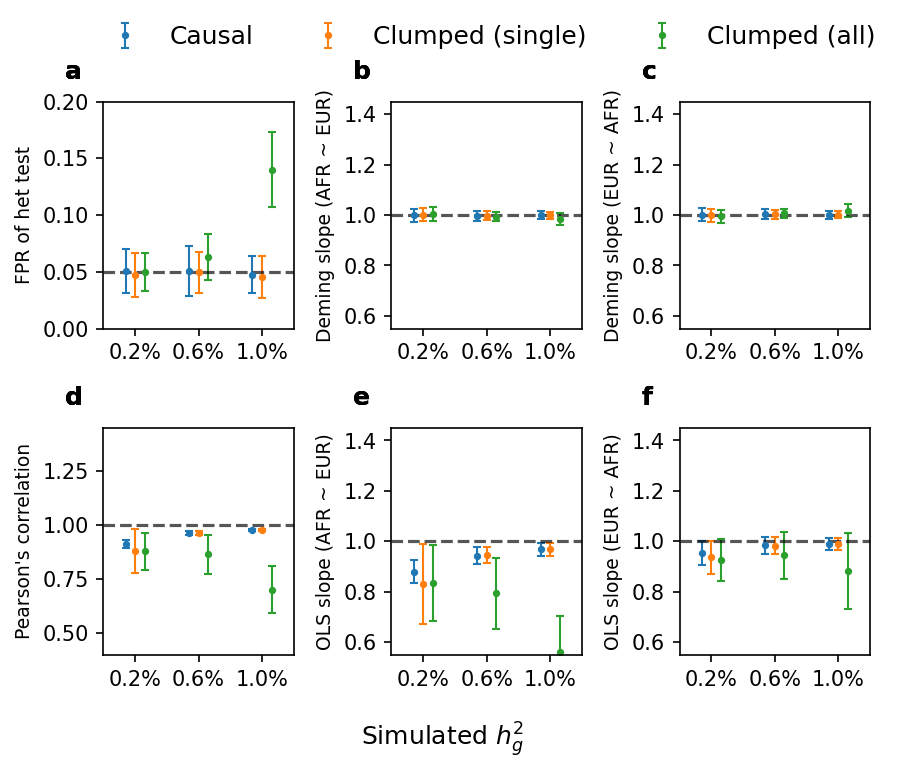

In [9]:
y_var_list = [
    "het_fpr",
    "deming_afr~eur",
    "deming_eur~afr",
    "pearsonr",
    "ols_afr~eur",
    "ols_eur~afr",
]
y_label_list = [
    "FPR of het test",
    "Deming slope (AFR ~ EUR)",
    "Deming slope (EUR ~ AFR)",
    "Pearson's correlation",
    "OLS slope (AFR ~ EUR)",
    "OLS slope (EUR ~ AFR)",
]
dict_ylim = {
    "het_fpr": [0, 0.20],
    "pearsonr": [0.4, 1.45],
    "ols_afr~eur": [0.55, 1.45],
    "ols_eur~afr": [0.55, 1.45],
    "deming_afr~eur": [0.55, 1.45],
    "deming_eur~afr": [0.55, 1.45],
}
dict_hline = {
    "het_fpr": 0.05,
    "pearsonr": 1.0,
    "ols_afr~eur": 1.0,
    "ols_eur~afr": 1.0,
    "deming_afr~eur": 1.0,
    "deming_eur~afr": 1.0,
}

fig, axes = plt.subplots(figsize=(6, 4.5), ncols=len(y_var_list) // 2, nrows=2, dpi=150)
axes = axes.flatten()

# for causal SNPs and clumped SNPs
for group_i, group in enumerate(["causal", "clump-max", "clump"]):
    df_mean, df_sem = dict_df_plot[group]
    # filter for single causal variant
    df_mean = df_mean[df_mean.ncausal == 1].drop(columns=["ncausal"])
    df_sem = df_sem[df_sem.ncausal == 1].drop(columns=["ncausal"])

    # for each panel
    for i, (y_var, y_label) in enumerate(zip(y_var_list, y_label_list)):
        ax = axes[i]
        hsq_list = df_mean.hsq.unique()

        if i == 0:
            label = {
                "causal": "Causal",
                "clump-max": "Clumped (single)",
                "clump": "Clumped (all)",
            }[group]
        else:
            label = None

        ax.errorbar(
            np.arange(len(hsq_list)) - 0.15 + 0.15 * group_i,
            df_mean[y_var],
            yerr=df_sem[y_var] * 1.96,
            fmt=".",
            ms=5,
            mew=1,
            label=label,
            linewidth=1,
            capsize=2,
        )

        ax.axhline(y=dict_hline[y_var], color="black", ls="--", alpha=0.3)
        ax.set_xticks(np.arange(len(hsq_list)))
        ax.set_xticklabels([f"{hsq * 100}%" for hsq in hsq_list])
        ax.set_xlim(-0.5, len(hsq_list) - 0.5)

        ax.set_ylabel(y_label, fontsize=9)

        ax.set_ylim(dict_ylim[y_var])

        # annotation
        ax.text(
            -0.2,
            1.1,
            string.ascii_lowercase[i],
            transform=ax.transAxes,
            size=12,
            weight="bold",
        )

# trick to put title in the same row
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    ncol=5,
    loc="center",
    bbox_to_anchor=[0.55, 1.0],
    frameon=False,
    fontsize=12,
)

fig.text(
    0.5,
    -0.05,
    "Simulated $h_g^2$",
    fontsize=12,
    ha="center",
)

plt.tight_layout()

plt.show()

In [10]:
# dict_df_plot = {}

# for group in ["causal", "clump"]:
#     df_plot = summarize_res(
#         dict_df_res[group].groupby(["ncausal", "hsq", "sim_i"])
#     ).drop(columns=["sim_i"])
#     df_plot_mean = df_plot.groupby(["ncausal", "hsq"]).mean().reset_index()
#     df_plot_sem = df_plot.groupby(["ncausal", "hsq"]).sem().reset_index()

#     dict_df_plot[group] = (df_plot_mean, df_plot_sem)

# for group in ["causal", "clump"]:
#     print(group + ":")
#     df_plot_mean, df_plot_se = dict_df_plot[group]
#     display(
#         df_plot_mean.set_index(["ncausal", "hsq"]).round(3).astype(str)
#         + "±"
#         + df_plot_se.set_index(["ncausal", "hsq"]).round(3).astype(str)
#     )

# for group in ["causal", "clump"]:
#     print(group + ":")
#     df_plot_mean, df_plot_sem = dict_df_plot[group]
#     display(
#         df_plot_mean.set_index(["ncausal", "hsq"]).round(3).astype(str)
#         + "±"
#         + df_plot_sem.set_index(["ncausal", "hsq"]).round(3).astype(str)
#     )

In [11]:
# yvar_list = [
#     "het_fpr",
#     "deming_afr~eur",
# ]
# dict_ylabel = {
#     "het_fpr": "False positive rate",
#     "deming_afr~eur": "Deming slope",
# }
# dict_ylim = {
#     "het_fpr": [0, 0.65],
#     "deming_afr~eur": [0.4, 1.1],
# }
# dict_yticks = {
#     "het_fpr": [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
#     "deming_afr~eur": [np.round(f, 1) for f in np.linspace(0.4, 1.1, 8)],
# }
# fig, axes = plt.subplots(
#     figsize=(4, 4), nrows=2, ncols=2, dpi=150, sharex=True, sharey="row"
# )
# for group_i, group in enumerate(["causal", "clump"]):
#     df_mean, df_sem = dict_df_plot[group]
#     # filter for multiple causal
#     df_mean = df_mean[df_mean.ncausal > 3]
#     df_sem = df_sem[df_sem.ncausal > 3]

#     for yvar_i, yvar in enumerate(yvar_list):
#         ax = axes[yvar_i, group_i]
#         for hsq_i, hsq in enumerate(df_plot.hsq.unique()):
#             df_mean_tmp = df_mean[df_mean.hsq == hsq]
#             df_sem_tmp = df_sem[df_sem.hsq == hsq]
#             ax.errorbar(
#                 np.arange(len(df_mean_tmp.ncausal)),
#                 df_mean_tmp[yvar],
#                 yerr=df_sem_tmp[yvar] * 1.96,
#                 fmt=".--",
#                 label=f"{hsq * 100}%",
#                 ms=3,
#                 linewidth=0.75,
#                 mew=0.75,
#                 capsize=2,
#             )

#         ax.axhline(y=dict_hline[yvar], color="black", ls="--", alpha=1.0, lw=0.5)
#         ax.set_xticks(np.arange(len(df_mean_tmp.ncausal)))

#         #         ax.set_xticklabels(df_mean_tmp.ncausal, fontsize=9)
#         ax.set_xticklabels([str(i) for i in (df_mean_tmp.ncausal - 1) / 20], fontsize=9)
#         ax.set_yticks(dict_yticks[yvar])
#         ax.set_yticklabels(dict_yticks[yvar], fontsize=9)
#         if group_i == 0:
#             ax.set_ylabel(dict_ylabel[yvar], fontsize=9)
#             ax.set_ylim(dict_ylim[yvar])

#         if group == "causal":
#             ax.set_title("Causal SNPs", fontsize=10)
#         elif group == "clump":
#             ax.set_title("Clumped SNPs", fontsize=10)

#         # annotation
#         ax.text(
#             -0.05,
#             1.05,
#             string.ascii_lowercase[yvar_i * 2 + group_i],
#             transform=ax.transAxes,
#             size=12,
#             weight="bold",
#         )

# # trick to put title in the same row
# handles, labels = axes[0, 0].get_legend_handles_labels()
# ph = [plt.plot([], marker="", ls="")[0]]  # Canvas
# handles = ph + handles
# labels = ["Simulated $h_g^2$:"] + labels  # Merging labels
# fig.legend(
#     handles,
#     labels,
#     ncol=6,
#     loc="center",
#     bbox_to_anchor=[0.5, 1.02],
#     frameon=False,
#     fontsize=9,
# )

# fig.text(
#     0.5,
#     -0.0,
#     "Number of causal variants per Mb",
#     fontsize=10,
#     ha="center",
# )


# plt.tight_layout()
# plt.show()

In [12]:
# df_tmp = dict_df_res["clump"].copy()
# df_tmp = df_tmp[(df_tmp.ncausal == 41) & (df_tmp.hsq == 0.006) & (df_tmp.sim_i == 3)]
# # df_tmp = df_tmp[(df_tmp.se1.between(0.01, 0.1)) & (df_tmp.se2.between(0.01, 0.1))]
# fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
# ax.scatter(df_tmp.coef1, df_tmp.coef2, s=1, alpha=0.5)
# lim = max(np.abs(df_tmp.coef1).max(), np.abs(df_tmp.coef2).max()) / 2
# ax.set_xlim(-lim, lim)
# ax.set_ylim(-lim, lim)
# slope = admix_genet_cor.locus.deming_regression(
#     x=df_tmp.coef1, y=df_tmp.coef2, sx=df_tmp.se1, sy=df_tmp.se2, no_intercept=True
# )
# print(slope)
# ax.plot([-lim, lim], [-lim * slope, lim * slope], "r--", alpha=0.5)
# ax.axhline(y=0, color="gray", ls="--", alpha=0.5)
# ax.axvline(x=0, color="gray", ls="--", alpha=0.5)

# ax.set_xlabel("European (20%)")
# ax.set_ylabel("African (80%)")